# Reproducing Movie Tag classification model in PyTorch

This notebook is my "getting started" notebook for PyTorch, and I will work with our dataset on Movie Tag extraction. https://doi.org/10.1109/ACCESS.2019.2963535

## 1 Load the dataset

We can load datasets from folders with ImageFolder. Later, we can split the dataset in test, val, train with random_split.

### 1.1 Auxiliary functions for dataset

Let's define a function to load the dataset:                                          

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np

# what: loads the movie tag dataset from a folder, and a dictionary with the label names
# input: folder, image size, and verbosity
# return: data object
# example: data = load_movie_dataset('./data/Movie',[128,128])
def load_movietag_dataset(folder,im_size=[128,128],verbose=True):
    data = datasets.ImageFolder(
         folder,
         transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(im_size)]),   
         target_transform=transforms.Lambda(lambda y: torch.zeros(51, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
         )
    
    if verbose:
        print(f"Loaded {len(data)} samples")

    return data

/home/miguel/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's define a function to do the splits of the dataset:

In [2]:
# what: split the dataset in train test
# input: dataset object, the percentage for train, verbosity
# return: data objects for train an val
# example: train, val = data_splits(data,0.8)
def data_splits(dataset,tr_percent=0.8,verbose=True):
    total_size = len(data)
    train_size = int(np.floor(tr_percent*total_size))
    test_size  = total_size-train_size
    
    # we can split the dataset randomnly like this
    train, test = torch.utils.data.random_split(data, [train_size, test_size])
    
    if verbose:
        print(f"Splitted the dataset with {len(data)} samples. Train: {len(train)}, Test: {len(test)}")
    
    return train, test
    

One function to check the status of the dataset (randomnly show images)

In [3]:
import matplotlib.pyplot as plt

def print_random_samples(data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item() # random number, get item because it's a random tensor
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(data.classes[torch.argmax(label).item()])
        plt.axis("off")
        plt.imshow(transforms.ToPILImage()(img)) #, cmap="rgb")
    plt.show()


The following function creates the data loaders (the iterators over the dataset).

In [24]:
from torch.utils.data import DataLoader

def create_data_loader(train,test,batch_size=32,cuda_avail=False):
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=cuda_avail)
    test_dataloader = DataLoader(test, batch_size=batch_size*2, num_workers=4, pin_memory=cuda_avail) 
    return train_dataloader, test_dataloader

### 1.2 Auxiliary functions for model

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model(model):
    print(model)
    print(f"Number of Parameters: {count_parameters(model)}")

## 2. Quick look to the dataset

We will load the dataset and print a couple of random samples

Loaded 34657 samples


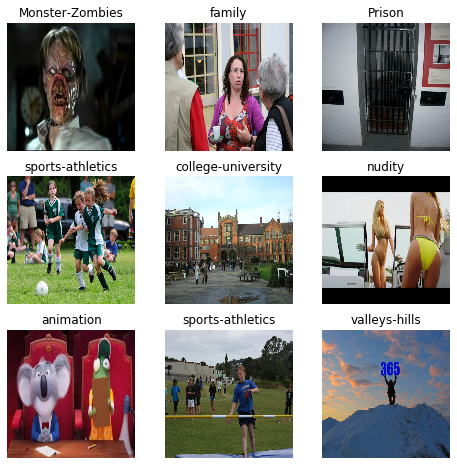

In [106]:
data = load_movietag_dataset('./data/Movie')
print_random_samples(data)

## 3. Model definition

Next, we define the model class

In [6]:
image_res=[128,128]  # input resolution to the model

In [7]:
from torch import nn

class MovieNet1(nn.Module):
    def __init__(self):
        super(MovieNet1, self).__init__()      ## required!    
        self.conv_stack = nn.Sequential(       ## This is a block of convolutions
            nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64,64,kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64,96,kernel_size=3, stride=2),
            nn.ReLU()           
        )
        self.dense_stack = nn.Sequential (   # This is the classifier
            nn.Flatten(),
            nn.Linear(7776,100),
            nn.ReLU(),
            nn.Linear(100,51),
            #nn.Softmax(dim=1)            # In Pytorch, softmax is embedded in the crossEntropy loss function
        )
        

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.dense_stack(x)
        return x
        #logits = self.linear_relu_stack(x)
        #return logits

## 4. Training the model

### 4.1. Check CUDA installation

Let's check if we have CUDA on the server

In [8]:
cuda_enabled = torch.cuda.is_available()

device = "cuda" if cuda_enabled else "cpu"
print(f"Using {device} device")

torch.cuda.get_device_name(torch.cuda.current_device())

Using cuda device


'NVIDIA GeForce RTX 2080'

### 4.2. Load the dataset and create data loaders
Load the dataset and split in test and train

In [9]:
# load the dataset
data = load_movietag_dataset('./data/Movie',image_res)

# split the data
train, test = data_splits(data,0.8)

Loaded 34657 samples
Splitted the dataset with 34657 samples. Train: 27725, Test: 6932


Show random samples

Create the data loaders for train and test

In [25]:
train_loader, test_loader = create_data_loader(train,test,batch_size=32,cuda_avail=cuda_enabled)

# For debugging purposes, I will get the first samples
train_features, train_labels = next(iter(train_loader))

### 4.3 Create the model

In [12]:
#Test the model. This is good to know the output shape of the network
model = MovieNet1()

In [112]:
print_model(model)

MovieNet1(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
    (8): ReLU()
  )
  (dense_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7776, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=51, bias=True)
  )
)
Number of Parameters: 894563


In [14]:
# send the model to the GPU
if cuda_enabled:
    model = model.cuda()

### 4.4. Optimizer and loss function


In [15]:
from torch.optim import Adam, SGD

learning_rate = 0.001

# defining the optimizer (receives the parameters of the model!)
optimizer = Adam(model.parameters(), lr=learning_rate)

# defining the loss function, in this caase cross entropy loss (it has softmax embedded!)
loss_func = nn.CrossEntropyLoss()

In [16]:
# send the loss to the GPU
if torch.cuda.is_available():
    loss_func = loss_func.cuda()

### 4.5 Train loop

In [17]:
import time

In [26]:
size = len(train_loader.dataset) # number of samples in training, TODO what if data augmentation?
epochs = 20

print (f"number of samples {size}")
print (f"number of epochs {epochs}")

t0 = time.time()

for epoch in range(epochs):
    print(f"epoch: {epoch}")
    for batch, (X, Y) in enumerate(train_loader):  # for each sample
        X=X.cuda()
        Y=Y.cuda()
        
        # FORWARD
        # Compute prediction and loss
        pred = model(X)
        # Calculate the loss
        loss = loss_func(pred, Y)
        
        # BACKWARD        
        loss.backward()        # the backpropagation phase, from loss to all recorded tensors        
        optimizer.step()       # one step of the optimizer
        optimizer.zero_grad()  # gradients are accumulated in PyTorch, need to zero them.

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}/{epoch:>3d}] | elpased time: {time.time() - t0:. 3f} s")            
            t0 = time.time()
            # print(
            #     'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
            #     format(epoch, batch_idx * len(data), len(train_loader.dataset),
            #            100. * batch_idx / len(train_loader), loss_data))

number of samples 27725
number of epochs 20
loss: 2.152632  [    0/27725] | elpased time: 0.23807096481323242 s
loss: 2.854829  [ 3200/27725] | elpased time: 3.973158359527588 s
loss: 2.932284  [ 6400/27725] | elpased time: 4.238894701004028 s
loss: 2.063077  [ 9600/27725] | elpased time: 4.300265312194824 s
loss: 2.726523  [12800/27725] | elpased time: 4.199294328689575 s
loss: 2.631905  [16000/27725] | elpased time: 4.059596061706543 s
loss: 2.639152  [19200/27725] | elpased time: 4.105349063873291 s
loss: 2.394736  [22400/27725] | elpased time: 4.548849582672119 s
loss: 2.238705  [25600/27725] | elpased time: 4.0379743576049805 s
loss: 2.303443  [    0/27725] | elpased time: 2.908879041671753 s
loss: 1.824082  [ 3200/27725] | elpased time: 4.3042967319488525 s
loss: 1.972362  [ 6400/27725] | elpased time: 4.2164342403411865 s
loss: 2.442361  [ 9600/27725] | elpased time: 4.040141344070435 s
loss: 2.226082  [12800/27725] | elpased time: 4.1555564403533936 s
loss: 1.998030  [16000/277

In [28]:
test_features, test_labels = next(iter(test_loader))

In [41]:
test_features = test_features.cuda()

ypred = model(test_features)

In [53]:
ypred.argmax(1)

tensor([23,  2, 23, 43,  7,  7, 25,  8,  7, 25, 45,  5, 30, 40, 20, 45, 38, 32,
        11, 38, 35, 23, 37, 23, 50,  8,  4, 14, 50, 45, 35, 41, 22, 43, 10, 28,
        42, 49, 46,  5, 34, 26, 15, 43, 25, 35, 23, 35, 38, 43, 45,  6, 21, 11,
        20, 10, 46, 22, 35, 45, 43, 32, 41, 31], device='cuda:0')

In [54]:
test_labels.argmax(1)

tensor([15, 45, 23, 43,  7,  7, 29,  8,  7, 25, 45, 30, 37, 12, 20, 35, 28,  5,
        50, 35, 28,  2, 19, 49, 42, 14,  4, 15, 50, 45, 35, 38, 50, 43,  5, 28,
        33, 50, 32, 37, 15, 26, 15, 43,  8, 46, 23, 35, 14, 43, 45, 43, 26, 32,
        10, 46, 46, 50, 49, 36, 46, 20, 41, 37])

In [56]:
sum(ypred.argmax(1) == test_labels.argmax(1).cuda())

tensor(24, device='cuda:0')